# Installation of Packages

In [3]:
# !pip install -q tensorflow_datasets
# !pip install -q datasets
# !pip install -q keras_cv
# !pip install -q keras_hub
# !pip install -q datasets

# Download Dataset from external source

# Importing packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import  metrics
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import ops
from tensorflow.keras import regularizers
from tensorflow.keras import applications
from tensorflow.keras import backend
from tensorflow import keras

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow_hub as hub


import tensorflow_datasets as tfds
import warnings
# import keras_cv
# import keras_hub

In [5]:
warnings.filterwarnings("ignore")

# Reading Data

In [6]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers", 
    split=["train[:90%]", "train[90%:]"], 
    as_supervised=True
)

# Data Inspection

In [7]:
print(train_dataset)
print(val_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [8]:
num_train = train_dataset.cardinality() 
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

Number of training examples: 3303
Number of validation examples: 367


 # Data Visualization

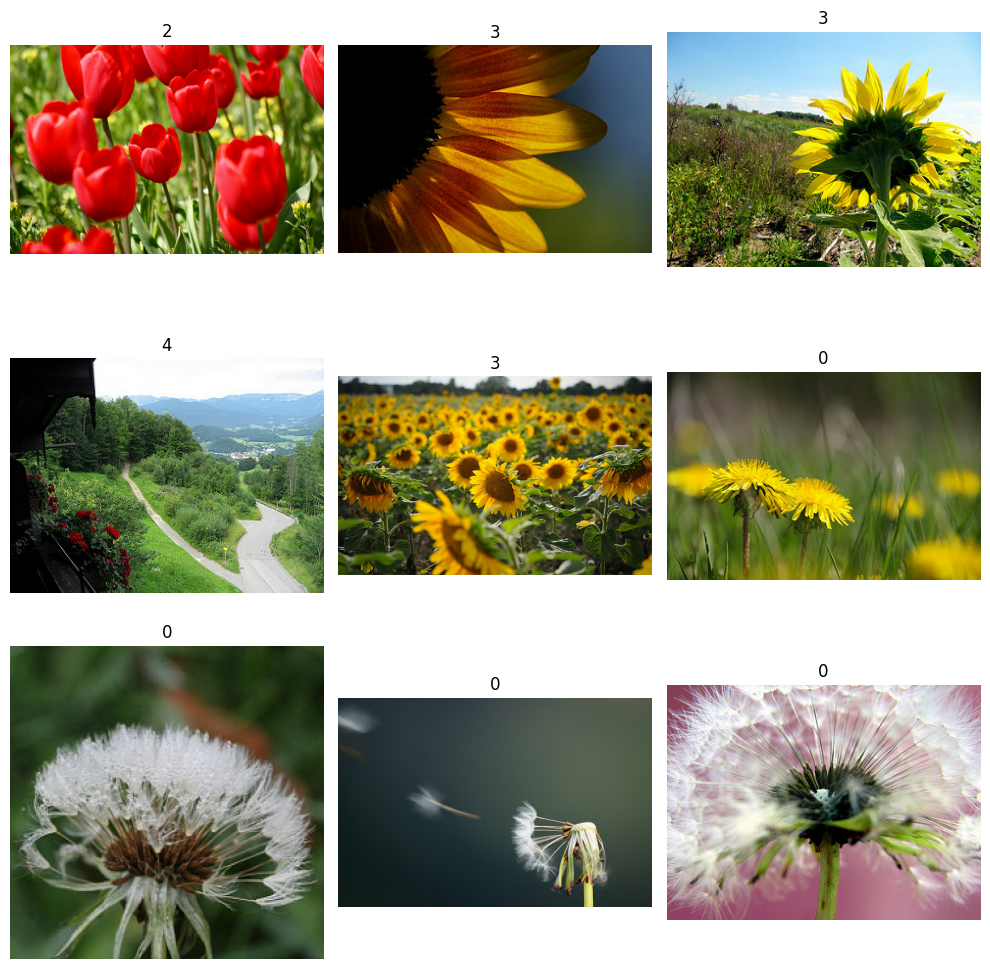

In [9]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")
plt.tight_layout()

# Data Preprocessing

In [10]:
batch_size = 64 
resize_bigger = 280
num_classes = 5
patch_size = 4  # 2x2, for the Transformer blocks.
image_size = 256
expansion_factor = 2  # expansion factor for the MobileNetV2 blocks.
input_shape = (image_size, image_size, 3)

In [11]:
def preprocess_dataset(is_training=True):
    def _pp(image, label):
        if is_training:
            # Resize to a bigger spatial resolution and take the random
            # crops.
            image = tf.image.resize(image, (resize_bigger, resize_bigger))
            image = tf.image.random_crop(image, (image_size, image_size, 3))
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, (image_size, image_size))
        label = tf.one_hot(label, depth=num_classes)
        return image, label

    return _pp

In [12]:
def prepare_dataset(dataset, is_training=True):
    if is_training:
        dataset = dataset.shuffle(batch_size * 10)
        
    dataset = dataset.map(preprocess_dataset(is_training), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [13]:
print(train_dataset)
print(val_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [14]:
train_ds = prepare_dataset(train_dataset, is_training=True)
val_ds = prepare_dataset(val_dataset, is_training=False)

# Data Postprocessing

In [15]:
print(train_ds)
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


# Custom Functions

In [16]:
def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        activation= activations.swish,
        padding="same",
    )
    return conv_layer(x)


 

def correct_pad(inputs, kernel_size):
    img_dim = 2 if backend.image_data_format() == "channels_first" else 1
    input_size = inputs.shape[img_dim : (img_dim + 2)]
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)
    correct = (kernel_size[0] // 2, kernel_size[1] // 2)
    return (
        (correct[0] - adjust[0], correct[0]),
        (correct[1] - adjust[1], correct[1]),
    )


# Reference: https://git.io/JKgtC


def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = activations.swish(m)

    if strides == 2:
        m = layers.ZeroPadding2D(padding=correct_pad(m, 3))(m)
    m = layers.DepthwiseConv2D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False
    )(m)
    m = layers.BatchNormalization()(m)
    m = keras.activations.swish(m)

    m = layers.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    m = layers.BatchNormalization()(m)

    if keras.ops.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m


 

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(
            x3,
            hidden_units=[x.shape[-1] * 2, x.shape[-1]],
            dropout_rate=0.1,
        )
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x


def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with convolutions.
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
    non_overlapping_patches = layers.Reshape((patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Apply point-wise conv -> concatenate with the input features.
    folded_feature_map = conv_block(
        folded_feature_map, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = layers.Concatenate(axis=-1)([x, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )

    return local_global_features

# Model

In [17]:
def create_mobilevit(input_shape, num_classes=5):
    inputs = layers.Input(input_shape)
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

# Training

In [18]:
def run_experiment(mobilevit_xxs):
    learning_rate = 0.002
    label_smoothing_factor = 0.1
    epochs = 20
    
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    loss_fn = losses.CategoricalCrossentropy(label_smoothing=label_smoothing_factor)
    
   
    mobilevit_xxs.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    
    checkpoint_callback = callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = mobilevit_xxs.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )
    mobilevit_xxs.load_weights(checkpoint_filepath)
    
    evaluation = mobilevit_xxs.evaluate(val_ds)
   
    return mobilevit_xxs, history, evaluation

In [19]:
 mobilevit_xxs = create_mobilevit(input_shape, num_classes=num_classes)

In [20]:
#mobilevit_xxs.summary()

In [21]:
mymodel, history, evaluation = run_experiment(mobilevit_xxs)

Epoch 1/20


I0000 00:00:1733228532.246586    1920 service.cc:145] XLA service 0x7dc134005740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733228532.246670    1920 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733228532.246678    1920 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733228584.670346    2039 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_72', 3876 bytes spill stores, 6992 bytes spill loads

I0000 00:00:1733228586.832749    2037 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_329', 7076 bytes spill stores, 11328 bytes spill loads

I0000 00:00:1733228597.151547    2037 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_172', 1028 bytes spill stores, 1028 bytes spill loads

I0000 00

51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.3658 - loss: 1.4821

I0000 00:00:1733228776.595606    2271 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_114', 4040 bytes spill stores, 7160 bytes spill loads

I0000 00:00:1733228785.872704    2270 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_72', 3876 bytes spill stores, 6992 bytes spill loads

I0000 00:00:1733228797.713750    2270 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_329', 7076 bytes spill stores, 11328 bytes spill loads

I0000 00:00:1733228802.225265    2271 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_74', 3876 bytes spill stores, 6992 bytes spill loads

I0000 00:00:1733228819.533015    2270 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_116', 4040 bytes spill stores, 7160 bytes spill loads

I0000 00:00:1733

52/52 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - accuracy: 0.3684 - loss: 1.4782 - val_accuracy: 0.1662 - val_loss: 1.7419
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 434ms/step - accuracy: 0.5436 - loss: 1.1874 - val_accuracy: 0.1907 - val_loss: 1.6565
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 417ms/step - accuracy: 0.6035 - loss: 1.1061 - val_accuracy: 0.1907 - val_loss: 1.6773
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 409ms/step - accuracy: 0.6336 - loss: 1.0711 - val_accuracy: 0.1907 - val_loss: 1.9879
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 409ms/step - accuracy: 0.6915 - loss: 0.9928 - val_accuracy: 0.1907 - val_loss: 1.9105
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 414ms/step - accuracy: 0.7123 - loss: 0.9553 - val_accuracy: 0.1907 - val_loss: 3.1817
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 415ms/step - accuracy: 0.7486 - loss: 0.9048 - val_accuracy: 0.1907 - val_loss: 2.4046
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 425ms/step - accuracy: 0.7582 - loss: 0.8784 - val_accuracy: 0.2071 

# Evaluation

In [22]:
# accuracy = model.evaluate(pipeline_validation)[1] * 100
# print("Accuracy: {:.2f}%".format(accuracy))

In [23]:
_, accuracy = evaluation
print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

Validation accuracy: 77.38%


In [24]:
# true_labels = tf.concat([label[1] for label in tf_test_dataset], axis=0)
# predictions = tf.argmax(model.predict(tf_test_dataset), axis=-1)

In [25]:
# cm = confusion_matrix(true_labels, predictions)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(cm.shape[0]))
# disp.plot(cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
# plt.show()

In [26]:
def make_plot(metric):
  plt.plot(history.history[metric ])
  plt.plot(history.history['val_'+metric ])
  plt.title( 'Model '+metric )
  plt.ylabel( metric.capitalize() )
  plt.xlabel( 'Epoch' )
  plt.legend([ 'Train' , 'Validation' ], loc='upper left' )
  plt.show()

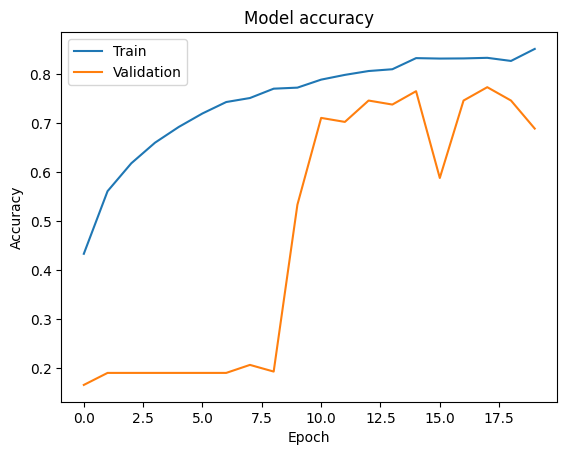

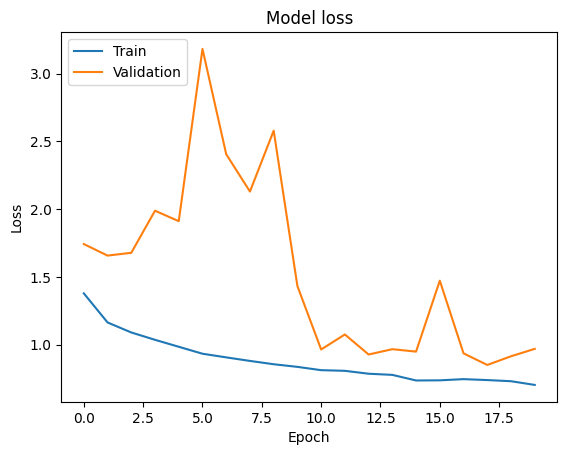

In [27]:
make_plot('accuracy')
make_plot('loss')

# Inference

# Deploy

In [28]:
 
# tf.saved_model.save(mymodel, "mobilevit_xxs")

 
 
# converter = tf.lite.TFLiteConverter.from_saved_model("mobilevit_xxs")
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [
#     tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
#     tf.lite.OpsSet.SELECT_TF_OPS,  # Enable TensorFlow ops.
# ]
# tflite_model = converter.convert()
# open("mobilevit_xxs.tflite", "wb").write(tflite_model)